# Armut Association Rule Based Recommender System

Association Rules is a rule-based machine learning technique that reveals the relationship between products in each purchasing behavior in basket analysis.

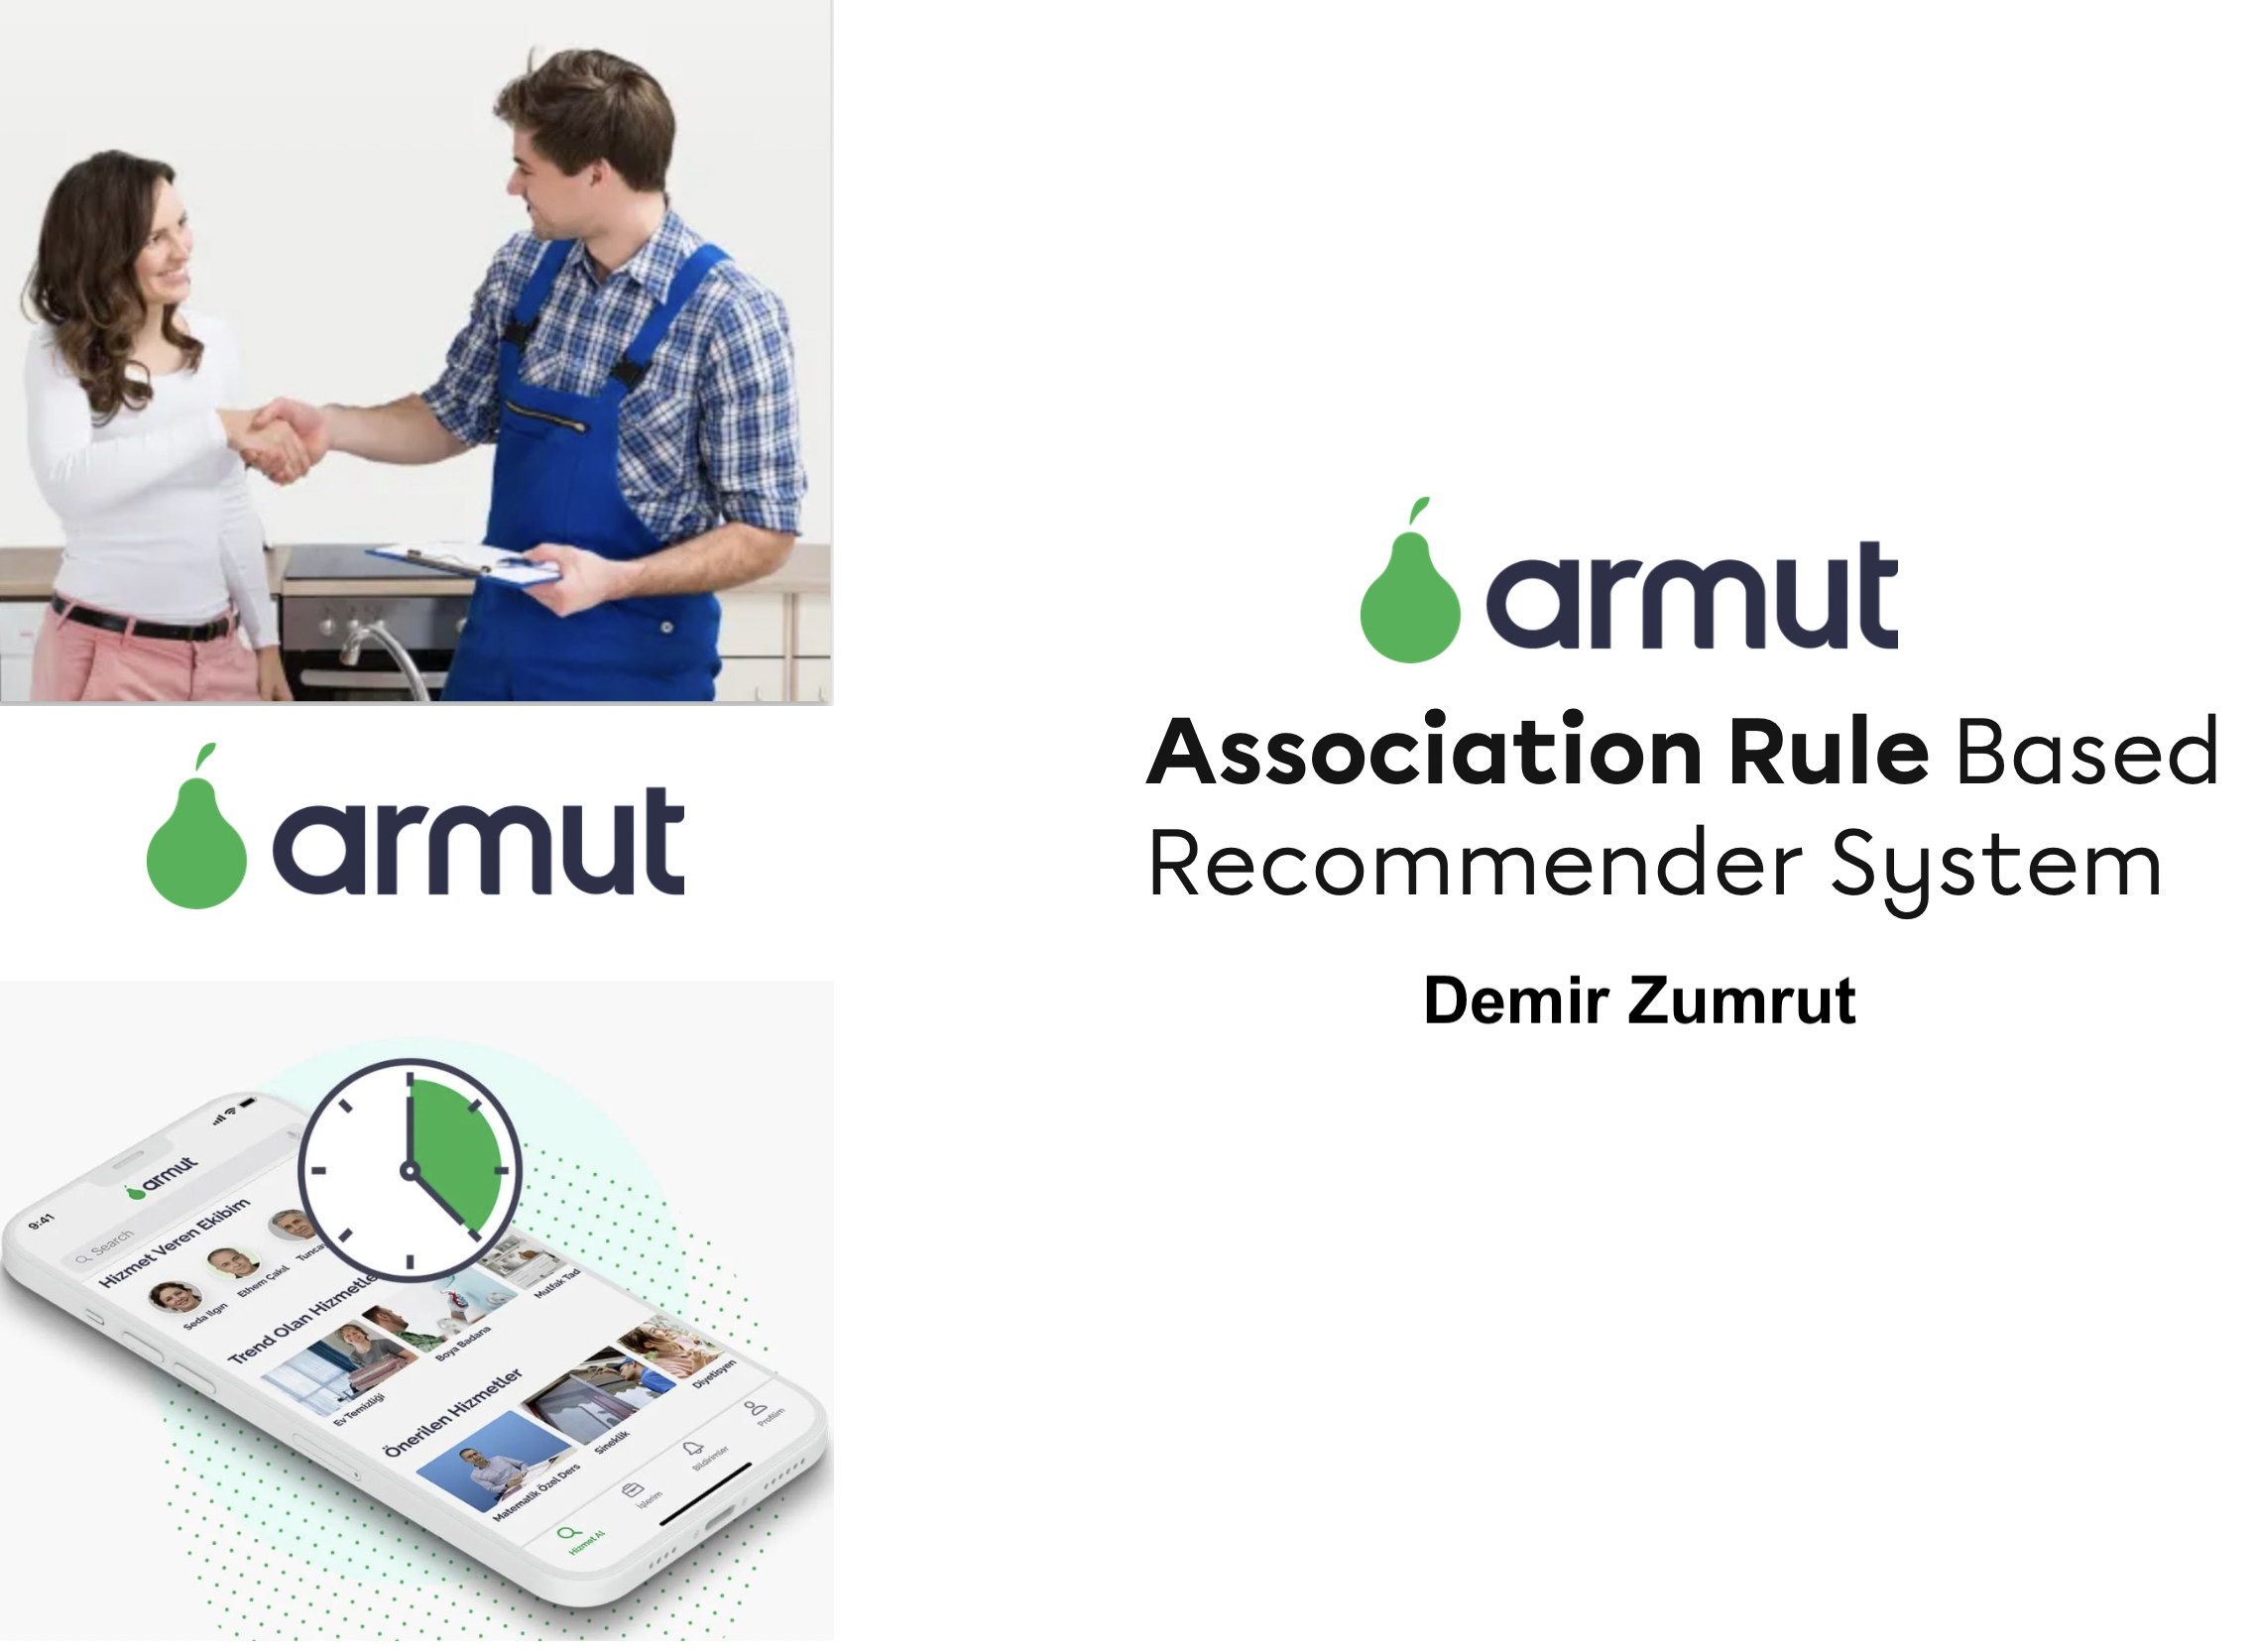

### Business Problem: 

Armut, Turkey's largest online service platform, brings together service providers and those who want to receive service.
It provides easy access to services such as cleaning, modification and transportation with a few touches on your computer or smart phone.

It is desired to create a product recommendation system with Association Rule Learning by using the data set containing the service users and the services and categories these users have received.

#### Dataset Story:

The data set consists of the services customers receive and the categories of these services. It contains the date and time information of each service received.

**UserId:** Customer number<br>
**ServiceId:** Anonymized services belonging to each category. (Example: Upholstery washing service under the cleaning category)<br>
A ServiceId can be found under different categories and refers to different services under different categories.<br>
(Example: Service with CategoryId 7 and ServiceId 4 is honeycomb cleaning, while ServiceId with CategoryId 2 is furniture assembly)<br>
**CategoryId:** Anonymized categories. (Example: Cleaning, transportation, renovation category)<br>
**CreateDate:** The date the service was purchased

*I cannot share the data due to data privacy

## 1. Importing the Libraries and Uploading Dataset

In [1]:
# need to install mlxtend
# !pip install mlxtend

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.expand_frame_repr', False)
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("armut_data.csv")
df.head()

,UserId,ServiceId,CategoryId,CreateDate
0,25446,4,5,2017-08-06 16:11:00
1,22948,48,5,2017-08-06 16:12:00
2,10618,0,8,2017-08-06 16:13:00
3,7256,9,4,2017-08-06 16:14:00
4,25446,48,5,2017-08-06 16:16:00


## 2. General Information About Dataset

In [4]:
def gen_info(df):
    print(30*"#" + "Shape".center(30) + 30*"#")
    print(df.shape)
    print("\n"+ 30*"#" + "Types".center(30) + 30*"#")
    print(df.dtypes)
    print("\n"+ 30*"#" + "Head".center(30) + 30*"#")
    print(df.head())
    print("\n"+ 30*"#" + "Tail".center(30) + 30*"#")
    print(df.tail())
    print("\n"+ 30*"#" + "Missing Values".center(30) + 30*"#")
    print(df.isnull().sum())
    print("\n"+ 30*"#" + "Quantiles".center(30) + 30*"#")
    print(df.describe([0.01, 0.05, 0.50, 0.95, 0.99]).T)

In [5]:
gen_info(df)

##############################            Shape             ##############################
(162523, 4)

##############################            Types             ##############################
UserId         int64
ServiceId      int64
CategoryId     int64
CreateDate    object
dtype: object

##############################             Head             ##############################
   UserId  ServiceId  CategoryId           CreateDate
0   25446          4           5  2017-08-06 16:11:00
1   22948         48           5  2017-08-06 16:12:00
2   10618          0           8  2017-08-06 16:13:00
3    7256          9           4  2017-08-06 16:14:00
4   25446         48           5  2017-08-06 16:16:00

##############################             Tail             ##############################
        UserId  ServiceId  CategoryId           CreateDate
162518   10591         25           0  2018-08-06 14:40:00
162519   10591          2           0  2018-08-06 14:43:00
162520   10591        

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162523 entries, 0 to 162522
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   UserId      162523 non-null  int64 
 1   ServiceId   162523 non-null  int64 
 2   CategoryId  162523 non-null  int64 
 3   CreateDate  162523 non-null  object
dtypes: int64(3), object(1)
memory usage: 5.0+ MB


# 3. Data Preparation

ServiceID represents a different service for each CategoryID. Let's combine ServiceID and CategoryID with "_" to create a new variable to represent these services

In [7]:
df["Service"] = df.apply(lambda row: str(row.ServiceId) +"_" + str(row.CategoryId) , axis=1)
df.head()

,UserId,ServiceId,CategoryId,CreateDate,Service
0,25446,4,5,2017-08-06 16:11:00,4_5
1,22948,48,5,2017-08-06 16:12:00,48_5
2,10618,0,8,2017-08-06 16:13:00,0_8
3,7256,9,4,2017-08-06 16:14:00,9_4
4,25446,48,5,2017-08-06 16:16:00,48_5


The data set consists of the date and time the services are received, there is no basket definition (invoice, etc.). In order to apply Association Rule Learning, a basket (invoice, etc.) definition must be created.

For the basket definition, let's say the services that each customer receives monthly.

For example; A basket of 4_5, 48_5, 6_7, 47_7 services received by the customer with id 25446 in the 8th month of 2017; 17_5, 14_7 services received in the 9th month of 2017 represent another basket. Baskets must be identified with a unique ID. First, let's create a new date variable that contains only the year and month.

In [8]:
df['Year_Month'] = pd.to_datetime(df['CreateDate'],format='%Y-%m').dt.to_period('M')
df.head()

,UserId,ServiceId,CategoryId,CreateDate,Service,Year_Month
0,25446,4,5,2017-08-06 16:11:00,4_5,2017-08
1,22948,48,5,2017-08-06 16:12:00,48_5,2017-08
2,10618,0,8,2017-08-06 16:13:00,0_8,2017-08
3,7256,9,4,2017-08-06 16:14:00,9_4,2017-08
4,25446,48,5,2017-08-06 16:16:00,48_5,2017-08


Let's combine the UserID and the newly created date variable with "_" and assign it to a new variable called BasketId.

In [9]:
df["BasketId"] = df.apply(lambda row: str(row.UserId) +"_" + str(row.Year_Month) , axis=1)
df.head()

,UserId,ServiceId,CategoryId,CreateDate,Service,Year_Month,BasketId
0,25446,4,5,2017-08-06 16:11:00,4_5,2017-08,25446_2017-08
1,22948,48,5,2017-08-06 16:12:00,48_5,2017-08,22948_2017-08
2,10618,0,8,2017-08-06 16:13:00,0_8,2017-08,10618_2017-08
3,7256,9,4,2017-08-06 16:14:00,9_4,2017-08,7256_2017-08
4,25446,48,5,2017-08-06 16:16:00,48_5,2017-08,25446_2017-08


# 4. Creating Association Rules

We will use Apriori Algorithm which is an algorithm that allows the implementation of Association Rules.

Apriori Algorithm consists of Support, Confidence, Lift metrics.

Support: Probability of X and Y being bought together.<br>
Confidence: Probability of buying Y when X is bought<br>
Lift: When X is purchased, the probability of buying Y also increases by a factor of lift.

In [10]:
df.groupby(['BasketId', 'Service']).agg({"Service": "count"}).head(20)

Service
BasketId      Service         
0_2017-08     46_4           1
              48_5           1
0_2017-09     48_5           1
              4_5            1
0_2018-01     30_2           1
...                        ...
10001_2017-09 26_7           1
10001_2018-05 38_4           1
              42_1           3
10001_2018-06 18_4           1
              35_11          1

[20 rows x 1 columns]

In [11]:
df.groupby(['BasketId', "Service"]).agg({"Service": "count"}).unstack()

Service                                                                                                                                                                                                                                                     
Service           0_8 10_9 11_11 12_7 13_11 14_7 15_1 16_8 17_5 18_4 19_6 1_4 20_5 21_5 22_0 23_10 24_10 25_0 26_7 27_7 28_4 29_0 2_0 30_2 31_6 32_4 33_4 34_6 35_11 36_1 37_0 38_4 39_10 3_5 40_8 41_3 42_1 43_2 44_0 45_6 46_4 47_7 48_5 49_1  4_5 5_11 6_7  7_3 8_5 9_4
BasketId                                                                                                                                                                                                                                                                  
0_2017-08         NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN NaN  NaN NaN NaN
0_2017-09         NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN NaN  NaN NaN NaN
0_2018-01         NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  1.0  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  1.0 NaN NaN
0_2018-04         NaN  NaN   NaN  NaN   NaN  1.0  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  1.0  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
10000_2017-08     NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
...               ...  ...   ...  ...   ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...   ...   ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...   ...  ...  ...  ...   ...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ...  ..  ..
99_2017-12        3.0  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  1.0  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
99_2018-01        1.0  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  1.0  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
99_2018-02        1.0  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
9_2018-03         NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN   NaN   NaN  1.0  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN
9_2018-04         NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  1.0 NaN  NaN  NaN  NaN   NaN   NaN  1.0  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   NaN NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN

[71220 rows x 50 columns]

We need to write 1 instead of values greater than 0 in the dataframe. And also we need to change NaN to 0.

In [12]:
df_a = df.groupby(['BasketId', "Service"])["Service"].count().unstack().fillna(0). \
applymap(lambda x: 1 if x > 0 else 0)

In [13]:
df_a.head().style.background_gradient(axis=0, cmap='PuBu') # better visual

Service,0_8,10_9,11_11,12_7,13_11,14_7,15_1,16_8,17_5,18_4,19_6,1_4,20_5,21_5,22_0,23_10,24_10,25_0,26_7,27_7,28_4,29_0,2_0,30_2,31_6,32_4,33_4,34_6,35_11,36_1,37_0,38_4,39_10,3_5,40_8,41_3,42_1,43_2,44_0,45_6,46_4,47_7,48_5,49_1,4_5,5_11,6_7,7_3,8_5,9_4
BasketId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_2017-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
0_2017-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
0_2018-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
0_2018-04,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
10000_2017-08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [14]:
df_a.shape

(71220, 50)

In [15]:
print("Total Number of Baskets -->", df_a.shape[0])
print("Total Number of Services -->", df_a.shape[1])

Total Number of Baskets --> 71220
Total Number of Services --> 50


Apriori Algorithm:

support > probability of finding the product in the basket (we gave min support = 0.01, accordingly, those greater than 0.01 will come)

In [16]:
frequent_itemsets = apriori(df_a,
                            min_support=0.001,
                            use_colnames=True)
frequent_itemsets.sort_values("support", ascending=False)

,support,itemsets
9,0.238121,(18_4)
22,0.130286,(2_0)
6,0.120963,(15_1)
43,0.067762,(49_1)
31,0.066568,(38_4)
...,...,...
365,0.001011,"(4_5, 43_2)"
407,0.001011,"(2_0, 11_11, 31_6)"
265,0.001011,"(25_0, 34_6)"
53,0.001011,"(38_4, 0_8)"


In [17]:
rules = association_rules(frequent_itemsets,
                          metric="support",
                          min_threshold=0.001)

In [18]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(15_1),(0_8),0.120963,0.019728,0.001334,0.011027,0.558977,-0.001052,0.991203
1,(0_8),(15_1),0.019728,0.120963,0.001334,0.067616,0.558977,-0.001052,0.942784
2,(0_8),(16_8),0.019728,0.014659,0.002429,0.123132,8.399845,0.002140,1.123705
3,(16_8),(0_8),0.014659,0.019728,0.002429,0.165709,8.399845,0.002140,1.174976
4,(2_0),(0_8),0.130286,0.019728,0.001474,0.011316,0.573606,-0.001096,0.991492
...,...,...,...,...,...,...,...,...,...
1279,"(25_0, 29_0)","(2_0, 22_0)",0.005378,0.016568,0.001123,0.208877,12.606983,0.001034,1.243084
1280,(2_0),"(22_0, 25_0, 29_0)",0.130286,0.002162,0.001123,0.008622,3.987219,0.000842,1.006515
1281,(22_0),"(2_0, 25_0, 29_0)",0.047515,0.002092,0.001123,0.023641,11.299919,0.001024,1.022070
1282,(25_0),"(2_0, 22_0, 29_0)",0.042895,0.002387,0.001123,0.026187,10.970636,0.001021,1.024440


antecedents > previous product (first product)<br>
consequents > 2nd product<br>
antecedent support > probability of first product being observed alone<br>
consequent support > probability of 2nd product being observed alone<br>
support > probability of seeing 2 products together<br>
confidence > probability of getting 2nd item when 1st item is bought<br>
lift > When the 1st item is bought, the probability of getting the 2nd item increases x times<br>

In [19]:
# let's check some of them with rules
rules[(rules["support"]>0.01) & (rules["confidence"]>0.2) & (rules["lift"]>2)]. \
sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
164,(33_4),(15_1),0.027310,0.120963,0.011233,0.411311,3.400299,0.007929,1.493211
361,(22_0),(2_0),0.047515,0.130286,0.016568,0.348700,2.676409,0.010378,1.335350
425,(25_0),(2_0),0.042895,0.130286,0.013437,0.313257,2.404371,0.007849,1.266432
159,(15_1),(2_0),0.120963,0.130286,0.033951,0.280673,2.154278,0.018191,1.209066
158,(2_0),(15_1),0.130286,0.120963,0.033951,0.260588,2.154278,0.018191,1.188833
357,(25_0),(22_0),0.042895,0.047515,0.011120,0.259247,5.456141,0.009082,1.285834
619,(9_4),(38_4),0.041393,0.066568,0.010067,0.243216,3.653623,0.007312,1.233418
356,(22_0),(25_0),0.047515,0.042895,0.011120,0.234043,5.456141,0.009082,1.249553


# 5. Let's suggest a service to a user who has received the 2_0 service in the last 1 month.

In [20]:
df.loc[df["Service"] == "2_0"].sort_values("CreateDate", ascending=False).head() # UserId = 10591 

,UserId,ServiceId,CategoryId,CreateDate,Service,Year_Month,BasketId
162519,10591,2,0,2018-08-06 14:43:00,2_0,2018-08,10591_2018-08
162502,11769,2,0,2018-08-06 09:30:00,2_0,2018-08,11769_2018-08
162497,12022,2,0,2018-08-06 08:47:00,2_0,2018-08,12022_2018-08
162484,11656,2,0,2018-08-06 07:17:00,2_0,2018-08,11656_2018-08
162469,18900,2,0,2018-08-06 04:30:00,2_0,2018-08,18900_2018-08


In [21]:
rules[rules["antecedents"] == {'2_0'}].sort_values("confidence", ascending=False).head() # with confidence

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
158,(2_0),(15_1),0.130286,0.120963,0.033951,0.260588,2.154278,0.018191,1.188833
360,(2_0),(22_0),0.130286,0.047515,0.016568,0.127169,2.676409,0.010378,1.091260
424,(2_0),(25_0),0.130286,0.042895,0.013437,0.103136,2.404371,0.007849,1.067168
90,(2_0),(13_11),0.130286,0.056627,0.012819,0.098394,1.737574,0.005442,1.046325
506,(2_0),(38_4),0.130286,0.066568,0.011191,0.085893,1.290295,0.002518,1.021140


In [22]:
rules[rules["antecedents"] == {'2_0'}].sort_values("lift", ascending=False).head(20) # or lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1266,(2_0),"(15_1, 22_0, 25_0)",0.130286,0.001797,0.001095,0.008406,4.677194,0.000861,1.006665
1255,(2_0),"(13_11, 22_0, 25_0)",0.130286,0.001881,0.001137,0.008729,4.639605,0.000892,1.006908
1003,(2_0),"(15_1, 37_0)",0.130286,0.003145,0.001797,0.013795,4.385941,0.001387,1.010798
955,(2_0),"(15_1, 22_0)",0.130286,0.006908,0.003651,0.028020,4.056104,0.002751,1.021721
973,(2_0),"(15_1, 25_0)",0.130286,0.004690,0.002471,0.018968,4.044520,0.001860,1.014554
...,...,...,...,...,...,...,...,...,...
1167,(2_0),"(38_4, 22_0)",0.130286,0.002247,0.001011,0.007759,3.453928,0.000718,1.005556
1147,(2_0),"(22_0, 29_0)",0.130286,0.005322,0.002387,0.018321,3.442790,0.001694,1.013242
769,(2_0),"(11_11, 25_0)",0.130286,0.007357,0.003286,0.025218,3.427562,0.002327,1.018323
1177,(2_0),"(22_0, 44_0)",0.130286,0.002527,0.001123,0.008622,3.411287,0.000794,1.006147


#### Let's prepare a function for suggestion

In [23]:
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"])[:])          
    return recommendation_list[0:rec_count]

In [24]:
arl_recommender(rules,'2_0',1) # if customer take servie 2_0, suggest 22_0 and 25_0

[['22_0', '25_0']]

In [25]:
arl_recommender(rules,'25_0', 3) # if customer take servie 25_0, suggest 2_0, 11_11,22_0,..

[['2_0', '11_11'], ['11_11', '22_0'], ['22_0', '29_0']]

In [26]:
arl_recommender(rules,'13_11', 3)

[['2_0', '25_0'], ['2_0', '22_0'], ['22_0']]

Hope it will be useful :)

[Linkedin](https://www.linkedin.com/in/demir-zumrut/)